In [1]:
import torch
import wandb
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import random_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cuda_num = 0
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'

torch.random.manual_seed(23)
np.random.seed(23)

# ResNet20

Я обучила ResNet20 с параметрами из [оригинальной статьи](https://arxiv.org/pdf/1512.03385.pdf)

In [3]:
from resnet import resnet20
from train import train, test
from utils import dataloader, graphics

In [4]:
params = {
    'batch_size': 128, 
    'lr': 1e-1,
    'weight_decay': 1e-4, 
    'momentum': 0.9,
    'epochs': 200
}

In [5]:
trainloader, valloader, testloader = dataloader(batch_size=128)

Train: 45000, Validation: 5000, Test: 10000


In [6]:
model = resnet20().to(device)
optim = torch.optim.SGD(model.parameters(), lr=params['lr'],
                      momentum=params['momentum'], weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=200)
criterion = nn.CrossEntropyLoss()

model.load_state_dict(torch.load(f'weights/resnet20.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

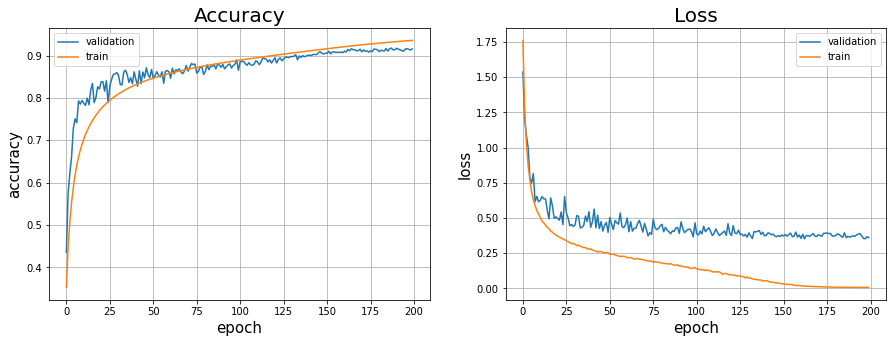

In [7]:
graphics("vysheslavova/MIL/lad3sl5n", "epoch")

**Итоговая точность модели 91%**

In [7]:
val_accuracy, val_loss = test(model, valloader, criterion)
test_accuracy, test_loss = test(model, testloader, criterion)
print('Validation')
print(f'Accuracy: {val_accuracy:.3}, Loss: {val_loss:.3}')
print()
print('Test')
print(f'Accuracy: {test_accuracy:.3}, Loss: {test_loss:.3}')

Validation
Accuracy: 0.916, Loss: 0.374

Test
Accuracy: 0.915, Loss: 0.406


# Pruning

In [8]:
import copy
from pruning import pruning

Метод для pruning'a: 
1. Для каждого сверточного слоя кластеризуется (с помощью kmeans) набор сверток, его представляющий (тензор весов). Необходимо проводить отдельную кластеризацию для каждого слоя.
2. Каждая исходная свертка в определенном слое заменяется на центроид кластера, к которому она была отнесена на шаге 1.

Для начала убедимся, что если для каждого слоя поставить количество кластеров равное количеству сверток, то качество модели должно остаться примерно таким же.

In [12]:
prune_model = copy.deepcopy(model)
for name, module in prune_model.named_modules():
    if isinstance(module, nn.Conv2d):
        n = module.weight.shape[0]
        module.weight = pruning(module.weight, n, device)

val_accuracy, val_loss = test(prune_model, valloader, criterion)
test_accuracy, test_loss = test(prune_model, testloader, criterion)
print('Validation')
print(f'Accuracy: {val_accuracy:.3}, Loss: {val_loss:.3}')
print()
print('Test')
print(f'Accuracy: {test_accuracy:.3}, Loss: {test_loss:.3}')

Validation
Accuracy: 0.916, Loss: 0.374

Test
Accuracy: 0.915, Loss: 0.406


Так оно и есть. Теперь попробую поставить для каждого слоя одинаковое количество кластеров (от 1 до 15). 

In [ ]:
for n in tqdm(reversed(range(1, 16)), total=len(range(5, 16))):
    prune_model = copy.deepcopy(model)
    with torch.no_grad():
        for name, module in prune_model.named_modules():
            if isinstance(module, nn.Conv2d):
                module.weight = pruning(module.weight, n)
    
    val_accuracy, val_loss = test(prune_model, valloader, criterion)
    train_accuracy, train_loss = test(prune_model, trainloader, criterion)

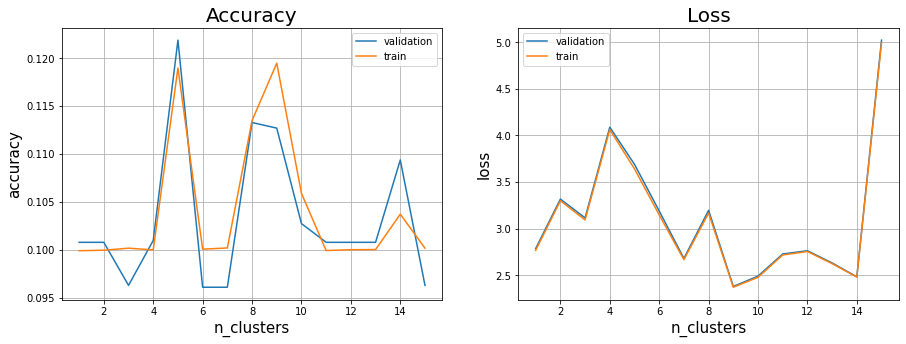

In [9]:
graphics("vysheslavova/MIL/3s67euky", "n_clusters")

Accuracy очень плохое. 
Теперь попробуем уменьшать на 1 количество кластеров в каждом слое, начинаю с максимального значения для этого слоя и посмотрим как будем падать accuracy.

In [ ]:
for i in tqdm(range(15), total=len(range(15))):
    prune_model = copy.deepcopy(model)
    with torch.no_grad():
        for name, module in prune_model.named_modules():
            if isinstance(module, nn.Conv2d):
                n = module.weight.shape[0] - i
                module.weight = pruning(module.weight, n)
    
    val_accuracy, val_loss = test(prune_model, valloader, criterion)
    train_accuracy, train_loss = test(prune_model, trainloader, criterion)

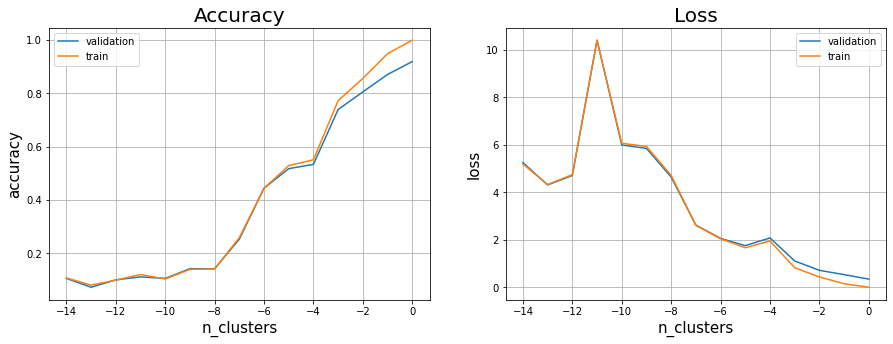

In [10]:
graphics("vysheslavova/MIL/3ts55wcj", "n_clusters")

# Итог

В конечно итоге, с помощью такого метода (с моими параметрами) сильно уменьшить модель не получится, не потеряя при этом в качестве. Возможно если делать кластеризацию поумнее или попробовать подобрать оптимальное количество кластеров, то такой подход можно использовать для дальнейшего обучения. 